In [1]:
########## SECTION 1 - Importing Required Packages and Functions ###############################
import pandas as pd
import numpy as np 
import time
from simulate import generateData
from linear_programs import checkMleExistence

In [2]:
########## SECTION 2 - Generating Simulated Dataset ############################################

# number of observations
n=200

# number of (Gaussian) covariates
p=40

# signal strength
signal_strength = 5

# Parameters for Distribution to draw Betas from. Betas ~ N(mu, stdev^2)
mu = 0
stdev = 1.0

# Generate the data
# - X is an (n,p+1) dimensional array with the n rows corresponding to observations and the p+1 columns
#   corresponding to the covariates + a column of 1's (for the intercept term)
# - Beta is the (p+1,) dimensional array of 'True' regression coefficients
# - y is the (n,) dimensional array of response values for the observations
# - means is the (n,) dimensional array of predicted values (probabilities in case of logistic)
# *THOUGHT: Perhaps we could use another term instead of means to avoid confusion with the systematic component?
# * perhaps y_hat, preds, etc?
X, Beta, y, means = generateData(dist = 'bernoulli', n = n, p = p, mu = mu, stdev = stdev, signal_strength = signal_strength) 

In [3]:
# Sanity Check 1: Should be equal to signal strength
Beta.dot(Beta)/n

5.0

In [4]:
# Sanity check 2 - Ignore
#from simulate import generateRandomBeta
#beta = generateRandomBeta(q=p, mu=mu, stdev=stdev)
#bb = beta * np.sqrt( (n * signal_strength) / beta.T.dot(beta).values[0,0] )
#bb.values.T.dot(bb.values)/n # check

In [5]:
# Combining the predictor and response data into a single pandas dataframe df
df = pd.DataFrame(X)
y = np.array(y)
y = np.where(y>0,1,-1)# Changed label 0 to -1, For convenience, we choose the label as {-1,1} instead of {0,1}
df['y'] = pd.Series(y)

(array([7., 6., 1., 6., 1., 3., 5., 2., 2., 3., 1., 3., 1., 2., 1., 0., 3.,
        2., 3., 2., 2., 2., 2., 1., 2., 1., 1., 1., 2., 0., 1., 0., 2., 2.,
        1., 1., 1., 0., 0., 0., 0., 3., 1., 1., 0., 0., 1., 1., 2., 2., 0.,
        1., 1., 2., 1., 0., 0., 0., 2., 2., 0., 5., 2., 0., 2., 3., 1., 1.,
        3., 2., 3., 2., 4., 1., 5., 2., 2., 1., 2., 1., 7., 1., 2., 1., 6.,
        2., 1., 1., 3., 3., 2., 1., 2., 5., 7., 1., 4., 3., 3.]),
 array([0.00322005, 0.0131766 , 0.02313315, 0.03308971, 0.04304626,
        0.05300282, 0.06295937, 0.07291592, 0.08287248, 0.09282903,
        0.10278558, 0.11274214, 0.12269869, 0.13265524, 0.1426118 ,
        0.15256835, 0.16252491, 0.17248146, 0.18243801, 0.19239457,
        0.20235112, 0.21230767, 0.22226423, 0.23222078, 0.24217734,
        0.25213389, 0.26209044, 0.272047  , 0.28200355, 0.2919601 ,
        0.30191666, 0.31187321, 0.32182976, 0.33178632, 0.34174287,
        0.35169943, 0.36165598, 0.37161253, 0.38156909, 0.39152564,
        0.

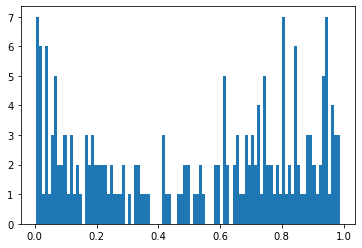

In [6]:
# QUICK ASIDE...
# Looking at distribution of means
import matplotlib.pyplot as plt
min_mean = min(means)
max_mean = max(means)
plt.hist(means, bins=np.arange(min_mean, max_mean, (max_mean-min_mean)/100))

(array([1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 2., 2., 1., 1.,
        0., 1., 3., 2., 1., 1., 2., 3., 3., 1., 3., 3., 3., 1., 2., 3., 3.,
        6., 4., 3., 3., 3., 3., 3., 2., 1., 4., 1., 5., 3., 2., 3., 8., 3.,
        5., 7., 7., 7., 3., 3., 9., 2., 7., 2., 2., 4., 3., 0., 3., 2., 6.,
        4., 0., 1., 3., 1., 1., 2., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0.]),
 array([-5.73513422, -5.60989071, -5.4846472 , -5.35940369, -5.23416018,
        -5.10891667, -4.98367316, -4.85842965, -4.73318614, -4.60794263,
        -4.48269912, -4.35745561, -4.2322121 , -4.10696859, -3.98172508,
        -3.85648157, -3.73123806, -3.60599455, -3.48075104, -3.35550753,
        -3.23026402, -3.10502051, -2.979777  , -2.85453349, -2.72928998,
        -2.60404647, -2.47880296, -2.35355945, -2.22831595, -2.10307244,
        -1.97782893, -1.85258542, -1.72734191, -1.6020984 , -1.47685489,
        -1.35161138, -1.22636787, -1.101124

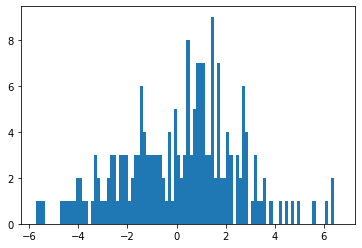

In [7]:
# Looking at distribution of systematic components (would prefer to call these the "means")
sys = X.dot(Beta)
min_sys = min(sys)
max_sys = max(sys)
plt.hist(sys, bins=np.arange(min_sys, max_sys, (max_sys-min_sys)/100))

In [8]:
# Checking percentiles of 'sys'. For signal strength of 5, 2.5th percentile should be > ~-4.472
# and 97.5th percentile should be < ~4.472
print(' 2.5th percentile: '+str(np.percentile(sys,2.5)))
print('97.5th percentile: '+str(np.percentile(sys,97.5)))

 2.5th percentile: -4.404488580217356
97.5th percentile: 4.963125478284858


In [9]:
########## SECTION 3 -  ############################################
########## SECTION 2 - Generating Simulated Dataset ############################################

# Given a data sample (y_i, X_i), start by choosing a "fine grid" of kappas <= 1/2
kappaArray = np.arange(0.2,0.61,0.01) # CHANGED TO SMALLEST VALUE TO 0.1

# Initializing list to hold proportions of times MLE *** does not **** exist at each kappa
kappaProportion = []

d1 = time.time()

# For each k_j in the grid, we do the following:
for kappa in kappaArray:
    
    # Set sample size to n_j =p / k_j (rounding off to nearest integer)
    # NOTE: FOR LARGE P THERE MAY NOT BE ENOUGH SAMPLES FOR SMALL KAPPA!
    sampleSize = int(round(p/kappa))

    # Here, we draw several samples and check to see if the MLE exists. B is the number of
    # rounds of sampling
    B = 50
    
    # nMleDNE is the total number of times the MLE *** Does Not Exist *** for each kappa (k_j). This
    # is initially set to 0
    nMleDNE = 0
    for i in range(B):
        subSample = df.sample(n=sampleSize) # draw the sample
        subSample =subSample.reset_index(drop = True) # Reindexing is necessary because df.sample draws 
                                                        # the originial index from the dataframe
        
        mleStatus = checkMleExistence(subSample) # check if MLE exists
        # Note that checkMleExistence returns a coded value. The list of coded values can be
        # found here: https://www.gurobi.com/documentation/9.0/refman/optimization_status_codes.html
        # We are most interested in the number of times (out of B times) MLE does not exist.
        # If MLE does not exist, the checkMleExistence function will return status code 2 indicating that the 
        # LP has an optimal solution. 
        
        if mleStatus == 2:
            nMleDNE +=1
            
    # Dividing nMleExist by B gives an estimate of the proportion of times the MLE exists.
    propMleDNE = nMleDNE/B
    kappaProportion.append(propMleDNE)
    

# Now, we need (kappa_j-1, kappa_j) such that kappa_j is the smallest value for which the proportion of times
# the MLE does not exist
uIdx = 0
for kappaProp in kappaProportion:
    if kappaProp>=0.5:
        uIdx = kappaProportion.index(kappaProp) # index of kappa_j
        break
if uIdx != 0:
    uKappa = kappaArray[uIdx] # kappa_j
    lKappa = kappaArray[uIdx-1] # kappa_j-1
else:
    print('Method Failed, All Subsamples are separable!')

d2 = time.time()
delta = round(d2 - d1)
print('Lower Bound of Kappa:',lKappa,'Upper Bound of Kappa:',uKappa, 'kappa proportions:', kappaProportion)
print('Time for the Code to run:',delta)

Using license file /home/nahid/gurobi.lic
Academic license - for non-commercial use only
Lower Bound of Kappa: 0.34000000000000014 Upper Bound of Kappa: 0.35000000000000014 kappa proportions: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12, 0.02, 0.18, 0.12, 0.48, 0.4, 0.3, 0.44, 0.68, 0.68, 0.62, 0.76, 0.86, 0.8, 0.92, 0.98, 0.94, 0.96, 1.0, 0.96, 0.96, 1.0, 0.96, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Time for the Code to run: 111
